In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [2]:
# Inlezen van CSV-bestand
dataPositions = pd.read_csv('../test-data/positions_xyz_128px_full.csv')
dataCoordinates = pd.read_csv('../test-data/red_ball_coordinates_128px_full.csv')
dataPositions.shape, dataCoordinates.shape

((4711, 3), (4711, 14))

In [3]:
combined = pd.concat([dataCoordinates, dataPositions], axis=1)
# remove the rows with to more than 3 NaN values

combined = combined.dropna(thresh=combined.shape[1]-3)
combined

,u0,v0,u1,v1,u2,v2,u3,v3,u4,v4,u5,v5,u6,v6,x,y,z
7,2.0,48.5,88.0,46.0,0.0,92.5,47.0,89.0,91.0,90.0,NaN,NaN,68.5,120.5,10.033960,3.860552,15.79055
8,2.0,50.0,88.5,47.0,0.5,93.0,47.0,90.0,91.0,90.0,NaN,NaN,68.5,120.5,10.006010,3.956561,15.88656
9,3.0,50.0,89.0,48.0,0.5,94.0,47.0,90.0,91.5,91.0,NaN,NaN,68.5,120.5,9.974871,4.051584,15.98158
10,3.5,51.0,89.5,48.5,1.0,95.0,48.0,91.0,92.0,92.0,NaN,NaN,68.5,120.5,9.940582,4.145517,16.07552
11,4.0,52.0,89.0,49.0,1.0,96.0,48.0,92.0,92.5,93.0,NaN,NaN,68.5,120.5,9.903183,4.238255,16.16825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3643,5.0,11.0,109.0,10.0,2.0,68.0,56.0,68.0,116.0,68.0,NaN,NaN,122.0,124.0,8.673822,1.483025,7.95000
3644,5.0,12.0,108.0,11.0,2.0,69.0,56.0,69.0,115.0,70.0,NaN,NaN,122.0,125.0,8.682408,1.524471,7.95000
3645,4.0,13.0,107.0,13.0,2.0,71.0,56.0,71.0,115.0,72.0,NaN,NaN,122.5,126.0,8.690976,1.567635,7.95000
3646,4.0,15.0,107.0,15.0,1.0,73.0,55.0,73.0,115.0,73.0,NaN,NaN,123.0,127.0,8.699528,1.612468,7.95000


In [4]:
X = combined.iloc[:, :14] # select all rows and columns from 0 to 13
y = combined.iloc[:, 14:] # select x y z output columns

### Data Preprocessing

In [5]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2)
dfX = imputer.fit_transform(X)
y = imputer.fit_transform(y)

### Splitting the dataset into the Training set and Test set

In [6]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(dfX, y, test_size=0.2, random_state=42)

# Splitting the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


In [7]:
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)
y_test_scaled = scaler_y.transform(y_test)

X_train_scaled.shape[0], X_val_scaled.shape[0], X_test_scaled.shape[0]

(944, 315, 315)

### Hyperparameter tuning

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor

# Define a parameter grid for the MLPRegressor
param_grid = {
    'model__hidden_layer_sizes': [ (50, 50), (150, 100, 50), (200, 150, 100)],
    'model__activation': ['identity', 'logistic', 'tanh', 'relu'],
    'model__solver': ['sgd', 'adam'],
    'model__learning_rate': ['constant', 'invscaling', 'adaptive'],
    'model__learning_rate_init': [0.001, 0.01, 0.1],
    'model__max_iter': [10000, 20000, 28000],
    'model__early_stopping': [True],
}

# Create a pipeline with an MLPRegressor model
pipeline = Pipeline([
    ('model', MLPRegressor(random_state=42))
])

# Perform a randomized search over the parameter grid
random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=100, cv=5, n_jobs=-1, verbose=2, random_state=42)

#### Train the model

In [9]:
random_search.fit(X_train_scaled, y_train_scaled)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\xande\venv\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
15 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\xande\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\xande\venv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\xande\venv\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\xande\venv\lib\site-

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('model',
                                              MLPRegressor(random_state=42))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'model__activation': ['identity',
                                                              'logistic',
                                                              'tanh', 'relu'],
                                        'model__early_stopping': [True],
                                        'model__hidden_layer_sizes': [(50, 50),
                                                                      (150, 100,
                                                                       50),
                                                                      (200, 150,
                                                                       100)],
                                        'model__learning_rate': ['constant',
                                                                 'invscaling',
                                                                 'adaptive'],
                                        'model__learning_rate_init': [0.001,
                                                                      0.01,
                                                                      0.1],
                                        'model__max_iter': [10000, 20000,
                                                            28000],
                                        'model__solver': ['sgd', 'adam']},
                   random_state=42, verbose=2)

#### Result of the hyperparameter tuning

In [10]:
model = random_search.best_estimator_

In [11]:
print('fBest parameters found:\n', random_search.best_params_)

fBest parameters found:
 {'model__solver': 'sgd', 'model__max_iter': 28000, 'model__learning_rate_init': 0.1, 'model__learning_rate': 'adaptive', 'model__hidden_layer_sizes': (150, 100, 50), 'model__early_stopping': True, 'model__activation': 'relu'}


#### Make Predictions

In [12]:
y_val_pred_scaled = model.predict(X_val_scaled)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)

#### Evaluate the model

In [13]:
from utils.evaluate import evaluate_model

mse_val, mae_val, r2_val = evaluate_model(y_val, y_val_pred, "Validation")

Mean Squared Error on Validation Set: 0.02518223487168306
Mean Absolute Error on Validation Set: 0.08996011591691883
R2 Score on Validation set: 0.9903877718949848


In [14]:
y_test_pred_scaled = model.predict(X_test_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

In [15]:
mse_test, mae_test, r2_test = evaluate_model(y_test, y_test_pred, "Test")

Mean Squared Error on Test Set: 0.0401116029181059
Mean Absolute Error on Test Set: 0.09943660326493141
R2 Score on Test set: 0.9882983546980918


#### Visualize the results
The test data is randomized so the plot won't show a clean trajectory

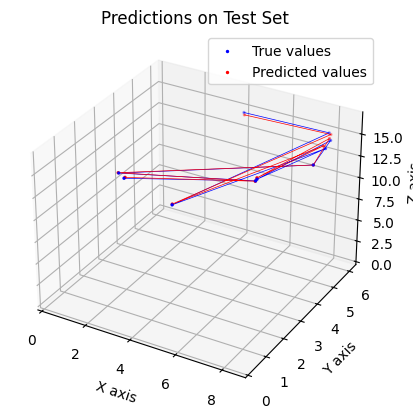

In [16]:
from utils.plot_maker_gaussian_process import plot_maker_3d

plot_maker_3d(np.array(y_test)[:10], np.array(y_test_pred)[:10], "Predictions on Test Set")

# Make Predictions on new data

In [17]:
test_data = pd.read_csv('../interpolated-data/red_ball_coordinates_128px_2024-02-27_13h38m.csv', delimiter=',', decimal='.')
test_result = pd.read_csv('../interpolated-data/positions_xyz_2024-02-27_13h38m.csv', delimiter=',', decimal='.')

In [18]:
new_combined = pd.concat([test_data, test_result], axis=1)
new_combined = new_combined.dropna(thresh=new_combined.shape[1]-3)
new_combined = new_combined

In [19]:
new_X = new_combined.iloc[:, :14]
new_y = new_combined.iloc[:, 14:]
new_X.shape, new_y.shape

((1474, 14), (1474, 3))

In [20]:
new_X_imputed = imputer.fit_transform(new_X)

new_X_scaled = scaler_X.fit_transform(new_X_imputed)
new_y_scaled = scaler_y.fit_transform(new_y)

In [21]:
new_y_pred_scaled = model.predict(new_X_scaled)

In [22]:
new_y_pred = scaler_y.inverse_transform(new_y_pred_scaled)

In [23]:
new_mse, new_mae, new_r2 = evaluate_model(new_y, new_y_pred, "New Data")

Mean Squared Error on New Data Set: 1.7683719094424142
Mean Absolute Error on New Data Set: 0.9664338417759901
R2 Score on New Data set: 0.44748429465661027


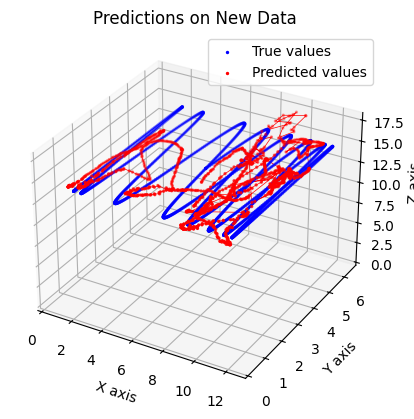

In [24]:
plot_maker_3d(np.array(new_y), np.array(new_y_pred), "Predictions on New Data")